# Importing Packages

In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import yahoo_fin.stock_info as si

from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error  
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Downloading Stock Price Data

In [111]:
# from stockprice.py
def create_data(ticker, start = "2021-01-04"):
    company = si.get_data(ticker)
    company = company.loc[start:] # 01-04 is the first Monday of 2021.
    company["date"] = company.index
    company = company.reset_index()
    company.drop(columns = "index", inplace = True)
    return company

In [179]:
df = create_data("SBUX")
df

,open,high,low,close,adjclose,volume,ticker,date
0,107.660004,107.750000,102.139999,103.099998,97.033081,8041500,SBUX,2021-01-04
1,102.919998,104.260002,102.800003,103.440002,97.353081,5721900,SBUX,2021-01-05
2,102.989998,105.209999,102.910004,104.190002,98.058952,5017200,SBUX,2021-01-06
3,104.489998,104.639999,102.949997,103.349998,97.268379,5057000,SBUX,2021-01-07
4,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,2021-01-08
...,...,...,...,...,...,...,...,...
728,103.440002,103.599998,102.470001,102.779999,102.779999,3206400,SBUX,2023-11-24
729,102.290001,103.089996,102.070000,102.360001,102.360001,7853600,SBUX,2023-11-27
730,101.959999,102.050003,100.889999,101.180000,101.180000,6848100,SBUX,2023-11-28
731,101.510002,101.690002,99.529999,99.849998,99.849998,8428500,SBUX,2023-11-29


# Cleaning Data

In [169]:
def clean_data(data):
    return data.dropna(ignore_index = True)

# Adding Features

In [170]:
def add_features(data):
    
    # add column for quarterly months: 3,6,9,12
    split_date = data["date"].astype(str).str.split("-", expand = True) # year, month, day
    data["month"] = split_date[1].astype("int")
    data["day"] = split_date[2].astype("int")
    data["year"] = split_date[0].astype("int")
    data["quarterly"] = np.where(df['month']%3==0,1,0) # identify end of quarter months
    
    # add open-close and low-high columns
    data["open-close"] = data["open"] - data["close"]
    data["low-high"] = data["low"] - data["high"]
    
    # add Estimated Moving Average using time window of 100 days
    data['EMA100'] = df['close'].ewm(span=100, adjust=False).mean()
    
    # set date as index
    data.date = pd.to_datetime(data.date)
    data.set_index('date', inplace=True)
    
    return data

In [180]:
df = clean_data(df)
df = add_features(df)
df

,open,high,low,close,adjclose,volume,ticker,month,day,year,quarterly,open-close,low-high,EMA100
date,,,,,,,,,,,,,,
2021-01-04,107.660004,107.750000,102.139999,103.099998,97.033081,8041500,SBUX,1,4,2021,0,4.560005,-5.610001,103.099998
2021-01-05,102.919998,104.260002,102.800003,103.440002,97.353081,5721900,SBUX,1,5,2021,0,-0.520004,-1.459999,103.106731
2021-01-06,102.989998,105.209999,102.910004,104.190002,98.058952,5017200,SBUX,1,6,2021,0,-1.200005,-2.299995,103.128182
2021-01-07,104.489998,104.639999,102.949997,103.349998,97.268379,5057000,SBUX,1,7,2021,0,1.139999,-1.690002,103.132575
2021-01-08,103.860001,105.760002,103.419998,105.669998,99.451836,5869700,SBUX,1,8,2021,0,-1.809998,-2.340004,103.182821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24,103.440002,103.599998,102.470001,102.779999,102.779999,3206400,SBUX,11,24,2023,0,0.660004,-1.129997,98.493376
2023-11-27,102.290001,103.089996,102.070000,102.360001,102.360001,7853600,SBUX,11,27,2023,0,-0.070000,-1.019997,98.569943
2023-11-28,101.959999,102.050003,100.889999,101.180000,101.180000,6848100,SBUX,11,28,2023,0,0.779999,-1.160004,98.621627


# Splitting and Normalizing Data

In [187]:
# keep features columns
features = ["close", "open-close", "low-high", "quarterly", "volume", "EMA100"]
df_feat_pred = df[features] # predictor data
df_close_target = df["close"] # target data

# normalize between 0 and 1
# define scalers
scaler_pred = MinMaxScaler() # for scaling multiple columns
scaler_target = MinMaxScaler() # for scaling one column
# scale data
scaled_pred = scaler_pred.fit_transform(df_feat_pred.values)
scaled_target = scaler_target.fit_transform(df_close_target.values.reshape(-1,1))

In [178]:
scaled_pred.shape

(733, 6)

In [205]:
# Split Data

seq_len = 50 # number of previous days used to make a prediction
index_close = df_feat_pred.columns.get_loc("close") 

# split data into training, validation, and testing data
train_len = int(0.7*len(df))
val_len = int(0.2*train_len) # validations set is 20% of training set

val_data = scaled_pred[:val_len,:]
train_data = scaled_pred[val_len:train_len, :]
test_data = scaled_pred[train_len - seq_len:, :]

def split_data(seq_len, data, index_close):
    x, y = [], []
    data_len = data.shape[0]

    for i in range(seq_len, data_len):
        x.append(data[i-seq_len:i,:]) # previous 50 day values
        y.append(data[i, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

x_train, y_train = split_data(seq_len, train_data, index_close)
x_val, y_val = split_data(seq_len, val_data, index_close)
x_test, y_test = split_data(seq_len, test_data, index_close)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(True if x_train[1][seq_len-1][0] == y_train[0] else False)

(361, 50, 6) (361,)
(52, 50, 6) (52,)
(220, 50, 6) (220,)
True


# Model

In [206]:
model = Sequential()
n_neurons = x_train.shape[1] * x_train.shape[2]
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train Model
callback = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size = 16, 
                    epochs = 50,
                    callbacks = [callback],
                    validation_data=(x_val, y_val)
                   )

Epoch 1/50
23/23 [==============================] - 4s 124ms/step - loss: 0.0324 - val_loss: 0.0068
Epoch 2/50
23/23 [==============================] - 3s 110ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 3/50
23/23 [==============================] - 3s 116ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 4/50
23/23 [==============================] - 3s 122ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 5/50
23/23 [==============================] - 3s 119ms/step - loss: 0.0040 - val_loss: 0.0128
Epoch 6/50
23/23 [==============================] - 3s 120ms/step - loss: 0.0041 - val_loss: 0.0015
Epoch 7/50
23/23 [==============================] - 3s 125ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 8/50
23/23 [==============================] - 3s 124ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 9/50
23/23 [==============================] - 3s 123ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/50
23/23 [==============================] - 3s 132ms/step - loss: 0.0022 - val_loss: 0.0029

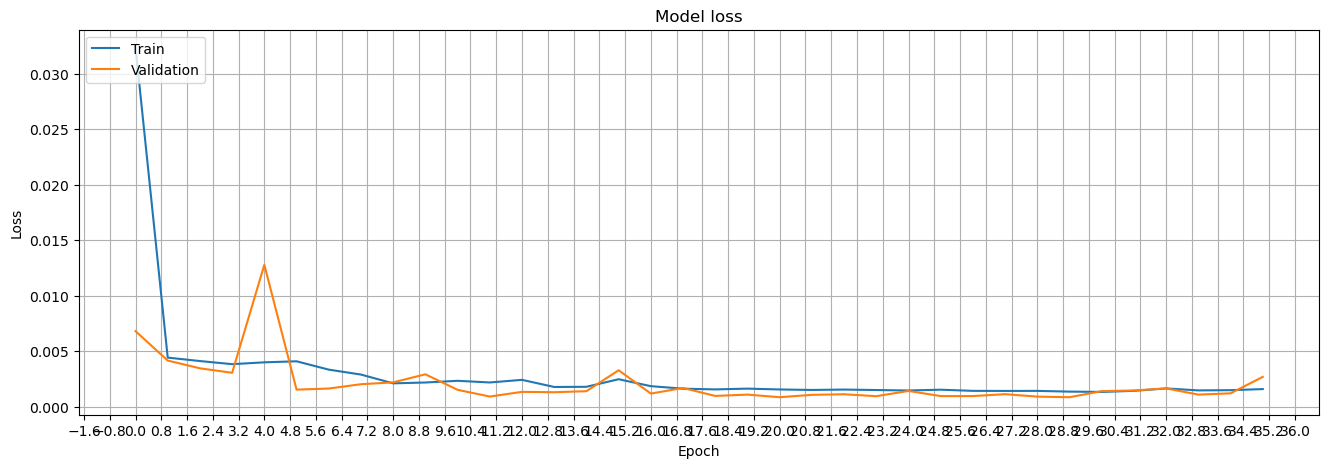

In [207]:
fig, ax = plt.subplots(figsize=(16, 5))

# Plot training loss
ax.plot(history.history["loss"], label="Train")

if 'val_loss' in history.history:
    ax.plot(history.history["val_loss"], label="Validation")

ax.set_title("Model loss")
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(50))
ax.legend(loc="upper left")
ax.grid()
plt.show()

7/7 [==============================] - 1s 69ms/step


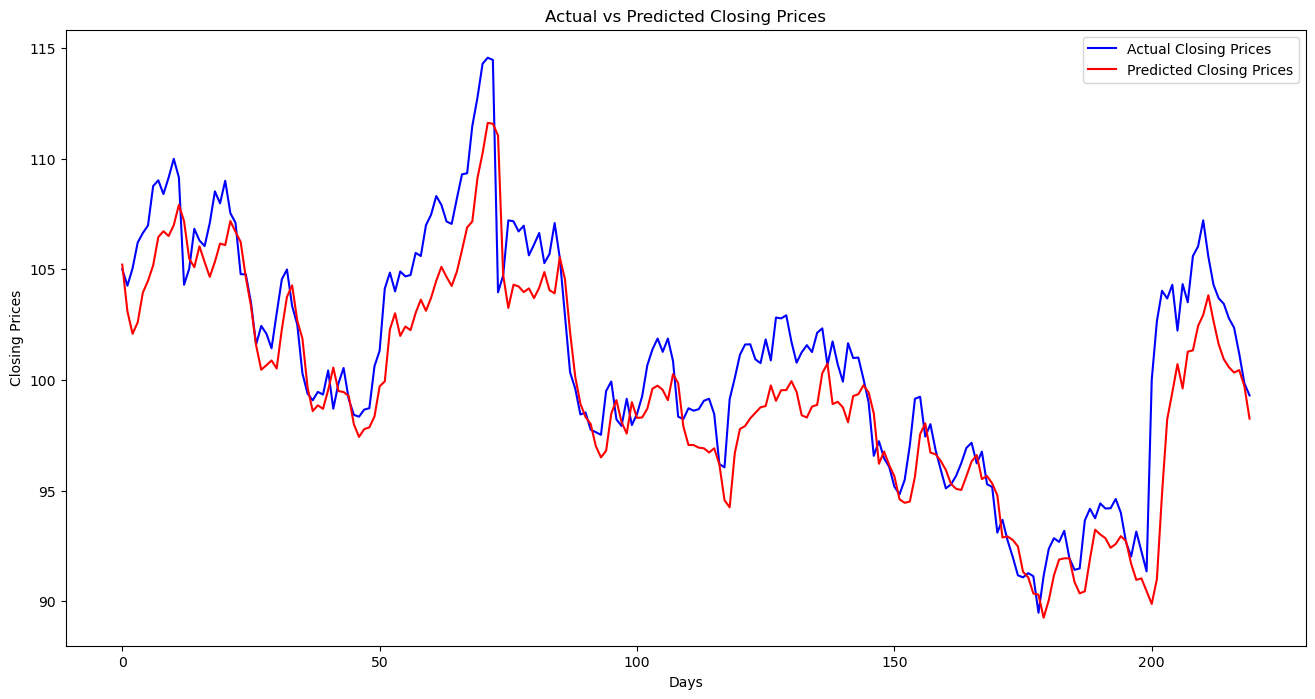

In [209]:
# Evaluate Model Performance

y_predicted_close = model.predict(x_test) # predict closing prices
y_predicted_close = scaler_target.inverse_transform(y_predicted_close) # unscale predictions
y_true_close= scaler_target.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(16, 8))
plt.plot(y_true_close, label='Actual Closing Prices', color='blue')
plt.plot(y_predicted_close, label='Predicted Closing Prices', color='red')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Days')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()